# Data distribution

This notebook investigates the information of IRMAS and OpenMIC-2018 datasets by three steps:
1. extract original genre information in both datasets 
2. align instrument classes and genre labels across datasets
3. summarize data distribution (i.e. number of samples per instrument class and per genre) after alignment

In [1]:
%matplotlib inline

import sys 
# add parental directory to Python path
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import os
import h5py
import collections as cl
from ast import literal_eval
from pprint import pprint
import re

import warnings
warnings.filterwarnings('ignore')

from deem import deem

In [2]:
# use one embedding example to investigate dataset information
embedding = 'vggish'
debias_method = ''
feature_dir='../embeddings.h5'

embeddings = h5py.File(feature_dir, "r")

## Original genre information
### IRMAS dataset

In [3]:
keys_ori = list(embeddings['irmas']['vggish']['keys'])
# some machine may need the following line of code; please comment out if not the case for you
keys_ori = np.array([str(k, 'utf-8') for k in keys_ori])  
key_clip = list(set(keys_ori))
print(len(key_clip))

6705


In [4]:
# number of samples for each instrument class
instruments = [key[key.index('[')+1:key.index(']')] for key in key_clip]
pprint(cl.Counter(instruments))  

Counter({'voi': 778,
         'gel': 760,
         'pia': 721,
         'org': 682,
         'gac': 637,
         'sax': 626,
         'vio': 580,
         'tru': 577,
         'cla': 505,
         'flu': 451,
         'cel': 388})


In [5]:
# extract genre information
group_matcher = re.compile(r'.*?\]\[(?P<class>\w+)\]\d.*')

def groupname(x):
    res = re.match(group_matcher, x)
    return res.groups()[0]

genres = [groupname(_) for _ in key_clip]
print(set(genres), len(genres))

{'pop_roc', 'cou_fol', 'jaz_blu', 'lat_sou', 'cla'} 6705


In [6]:
matcher = re.compile(r'.*?\[(?P<class>\w+)\].*')

def classname(x):
    res = re.match(matcher, x)
    return res.groups()[0]

instruments = [classname(_) for _ in key_clip]
print(set(instruments), len(instruments))

{'gel', 'voi', 'cla', 'pia', 'sax', 'cel', 'gac', 'vio', 'flu', 'tru', 'org'} 6705


In [7]:
# use a dict to align the instrument/genre labels between Openmic dataset (key) and IRMAS dataset (val)
instrument_align = {'cla': 'clarinet', 
                   'org': 'organ',
                   'cel': 'cello',
                   'vio': 'violin',
                   'gac': 'guitar-ac',
                   'voi': 'voice',
                   'gel': 'guitar-el',
                   'sax': 'saxophone',
                   'tru': 'trumpet',
                   'pia': 'piano',
                   'flu': 'flute'}

genre_align = {'pop_roc': 'pop_roc',
            'jaz_blu': 'jazz_blue',
            'cla': 'classical',
            'cou_fol': 'country_folk',
            'lat_sou': 'latin_soul'}

In [8]:
instruments = [instrument_align[key] for key in instruments]
print(set(instruments), len(instruments))

genres = [genre_align[key] for key in genres]
print(set(genres), len(genres))

{'flute', 'trumpet', 'violin', 'guitar-el', 'voice', 'cello', 'organ', 'saxophone', 'piano', 'guitar-ac', 'clarinet'} 6705
{'pop_roc', 'classical', 'latin_soul', 'jazz_blue', 'country_folk'} 6705


In [9]:
key_info = pd.DataFrame(columns=['instrument', 'genre', 'file_name'])
key_info['instrument'] = instruments
key_info['genre'] = genres
key_info['file_name'] = key_clip

In [10]:
genre_info = pd.DataFrame(columns=['instrument', 'genre', 'examples'])

for inst in set(instruments):
    for genre in set(genres):

        inst_genre_examples = key_info[(key_info['instrument'] == inst) & (key_info['genre'] == genre)]

        inst_genre = pd.DataFrame(columns=['instrument', 'genre', 'examples'])
        inst_genre['instrument'] = [inst]
        inst_genre['genre'] = [genre]
        inst_genre['examples'] = [len(inst_genre_examples)]

        genre_info = genre_info.append(inst_genre)

genre_info = genre_info.reset_index(drop=True)

In [11]:
# number of samples per each instrument class and each genre
instrument_class = [instrument_align[key] for key in instrument_align]
genre_class = [genre_align[key] for key in genre_align]

genre_num =pd.DataFrame(columns=instrument_class, index=genre_class)
for inst in instrument_class:
    for genre in genre_class:
        genre_num[inst][genre] = int(genre_info.loc[(genre_info['instrument'] == inst) & (genre_info['genre'] == genre)]['examples'])

genre_num['sum'] = list(pd.Series(genre_num.sum(1), dtype=int))
genre_table = genre_num.append(pd.Series(genre_num.sum(0), name='sum'))
genre_table

,clarinet,organ,cello,violin,guitar-ac,voice,guitar-el,saxophone,trumpet,piano,flute,sum
pop_roc,139,292,118,146,314,439,454,135,161,141,137,2476
jazz_blue,143,387,23,146,98,39,237,263,257,317,120,2030
classical,223,0,247,253,149,0,6,225,159,252,161,1675
country_folk,0,3,0,35,76,258,63,3,0,11,33,482
latin_soul,0,0,0,0,0,42,0,0,0,0,0,42
sum,505,682,388,580,637,778,760,626,577,721,451,6705


### OpenMIC dataset

In [12]:
param_grid = {'LR_param': {'C':[10**k for k in range(-8, 4, 1)]}, 
              'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

# only consider 10 mutual classes between Openmic and IRMAS dataset
with open("../data/openmic-2018/openmic_classmap_10.json", "r") as f: 
    openmic_class_map = json.load(f)
    
with open("../data/class_align.json", "r") as f: 
    class_align = json.load(f)

with open("../data/genre_map.json", "r") as f: 
    genre_map = json.load(f)

with open("../data/instrument_map.json", "r") as f: 
    instrument_map = json.load(f)

In [13]:
feature = np.array(embeddings["openmic"][embedding]["features"])
keys = np.array(embeddings["openmic"][embedding]["keys"])
# some machine may need the following line of code; please comment out if not the case for you
keys = np.array([str(k, 'utf-8') for k in keys])  
print(feature.shape, keys.shape)

key_clip = np.unique(keys)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

# key-label map using the information from the dataset source
data_root = "../data/openmic-2018/"

np_load_old = np.load   # save np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True,**k)   # modify the default parameters of np.load

Ytrue = np.load(os.path.join(data_root, "openmic-2018.npz"))["Y_true"]
Ymask = np.load(os.path.join(data_root, "openmic-2018.npz"))["Y_mask"]
sample_key = np.load(os.path.join(data_root, "openmic-2018.npz"))["sample_key"]

np.load = np_load_old   # restore np.load for future normal usage
del(np_load_old)

print(Ytrue.shape, Ymask.shape, sample_key.shape)

Y_true = []
Y_mask = []

for key in tqdm(key_clip):
    Y_true.append(Ytrue[sample_key==key])
    Y_mask.append(Ymask[sample_key==key])
    
Y_true = np.squeeze(np.array(Y_true))
Y_mask = np.squeeze(np.array(Y_mask))

print(feature_clip.shape, Y_true.shape, Y_mask.shape)

# train-test split
train_set = set(pd.read_csv(data_root + "openmic2018_train.csv", header=None, squeeze=True))
test_set = set(pd.read_csv(data_root + "openmic2018_test.csv", header=None, squeeze=True))
print("# Train: {},  # Test: {}".format(len(train_set), len(test_set)))

idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError("Unknown sample key={}! Abort!".format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

meta = pd.read_csv(data_root + "openmic-2018-metadata.csv")
train_genre_meta = list(meta["track_genres"][idx_train])
test_genre_meta = list(meta["track_genres"][idx_test])
len(train_genre_meta), len(test_genre_meta)

(180000, 128) (180000,)


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 128) (20000,)
(20000, 20) (20000, 20) (20000,)


  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 128) (20000, 20) (20000, 20)
# Train: 14915,  # Test: 5085


(14915, 5085)

In [14]:
meta = pd.read_csv(data_root + "openmic-2018-metadata.csv")
train_genre_meta = list(meta["track_genres"][idx_train])
test_genre_meta = list(meta["track_genres"][idx_test])
len(train_genre_meta), len(test_genre_meta)

(14915, 5085)

In [15]:
idx_genre_train = []
genre_train_openmic = []

for k in tqdm(range(len(train_genre_meta))):
    if isinstance(train_genre_meta[k], str):
        idx_genre_train.append(k)
        genre_excerpt = literal_eval(train_genre_meta[k])
        genre_train_openmic.append([item['genre_title']for item in genre_excerpt])

idx_genre_train = np.array(idx_genre_train)

idx_genre_test = []
genre_test_openmic = []

for k in tqdm(range(len(test_genre_meta))):
    if isinstance(test_genre_meta[k], str):
        idx_genre_test.append(k)
        genre_excerpt = literal_eval(test_genre_meta[k])
        genre_test_openmic.append([item['genre_title']for item in genre_excerpt])

idx_genre_test = np.array(idx_genre_test)

  0%|          | 0/14915 [00:00<?, ?it/s]

  0%|          | 0/5085 [00:00<?, ?it/s]

In [16]:
# print one example for sanity check
k = 200
pprint(genre_train_openmic[k:k+20])

[['Electronic', 'Indie-Rock'],
 ['Experimental', 'Free-Folk', 'Indie-Rock', 'Americana'],
 ['Experimental', 'Free-Folk', 'Indie-Rock', 'Americana'],
 ['Experimental', 'Free-Folk', 'Indie-Rock', 'Americana'],
 ['Electronic'],
 ['Audio Collage'],
 ['Audio Collage'],
 ['Audio Collage'],
 ['Electronic'],
 ['Bluegrass'],
 ['Bluegrass'],
 ['Bluegrass'],
 ['Bluegrass'],
 ['Bluegrass'],
 ['Folk'],
 ['Folk'],
 ['Rock'],
 ['Rock'],
 ['Rock'],
 ['Rock']]


In [17]:
# print one example
literal_eval(train_genre_meta[13])

[{'genre_id': '17',
  'genre_title': 'Folk',
  'genre_url': 'http://freemusicarchive.org/genre/Folk/'}]

  0%|          | 0/14915 [00:00<?, ?it/s]

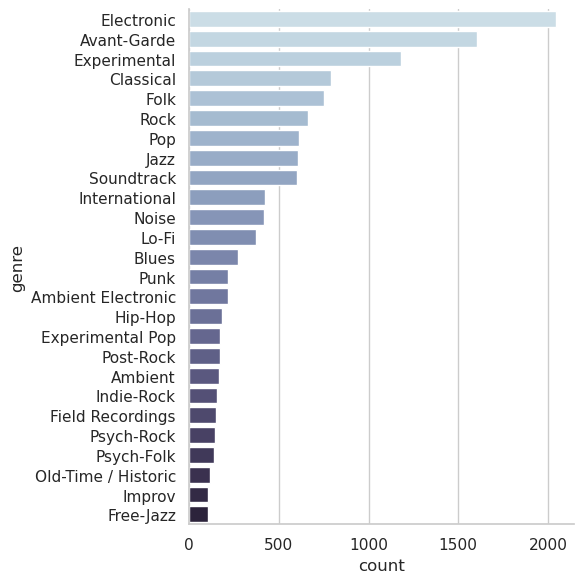

In [18]:
genre_train_openmic = []

for k in tqdm(range(len(train_genre_meta))):
    if isinstance(train_genre_meta[k], str):
        genre_train_openmic.append(literal_eval(train_genre_meta[k])[0]["genre_title"])
        
genre_all = cl.Counter(genre_train_openmic).most_common()
genre_train_openmic_plot = pd.DataFrame(columns=['genre', 'count'])

genre_train_openmic_plot['genre'] = [item[0] for item in genre_all]
genre_train_openmic_plot['count'] = [item[1] for item in genre_all]

genre_plot = genre_train_openmic_plot.loc[(genre_train_openmic_plot['count'] >= 100)]

sns.set_theme(context='notebook', style='whitegrid') # , font_scale=1.6)
sns.catplot(data=genre_plot, x='count', y='genre', kind='bar', height=6, aspect=1,
               legend_out=False, palette="ch:s=.25,rot=-.25")
plt.savefig('../results/openmic_train_genre_before.pdf', bbox_inches='tight')

## Genre alignment
(1) Merge labels and consider only genres with at least 100 examples in the OpenMIC-2018 dataset

In [19]:
add_info = 'global'
deb = deem(embedding = embedding, debias_method = debias_method, feature_dir='../embeddings.h5', 
           instrument_map=instrument_map, genre_map=genre_map, param_grid=param_grid, 
           class_align=class_align, add_info=add_info)

In [20]:
idx_genre_train, genre_train_openmic = deb.genre_extract(train_genre_meta)
idx_genre_test, genre_test_openmic = deb.genre_extract(test_genre_meta)

100%|██████████| 5085/5085 [00:00<00:00, 27258.19it/s]


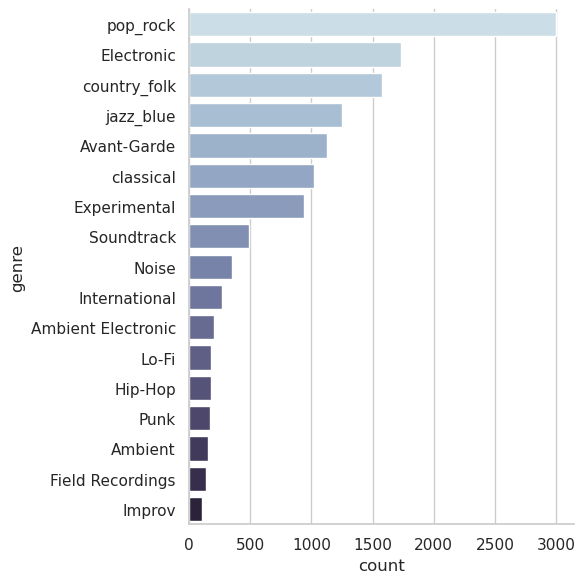

In [21]:
genre_all = cl.Counter(genre_train_openmic).most_common()
genre_train_openmic_plot = pd.DataFrame(columns=['genre', 'count'])

genre_train_openmic_plot['genre'] = [item[0] for item in genre_all]
genre_train_openmic_plot['count'] = [item[1] for item in genre_all]

genre_plot = genre_train_openmic_plot.loc[(genre_train_openmic_plot['count'] >= 100)]

sns.set_theme(context='notebook', style='whitegrid') # , font_scale=1.6)
sns.catplot(data=genre_plot, x='count', y='genre', kind='bar', height=6, aspect=1,
               legend_out=False, palette="ch:s=.25,rot=-.25")
plt.savefig('../results/openmic_train_genre_after.pdf', bbox_inches='tight')

(2) Align OpenMIC genres with that of IRMAS dataset

In [22]:
genre_train_openmic = np.array([item if item in genre_map else "other" for item in genre_train_openmic])
genre_test_openmic = np.array([item if item in genre_map else "other" for item in genre_test_openmic])

genre_train_openmic = genre_train_openmic[genre_train_openmic!="other"]
genre_test_openmic = genre_test_openmic[genre_test_openmic!="other"]

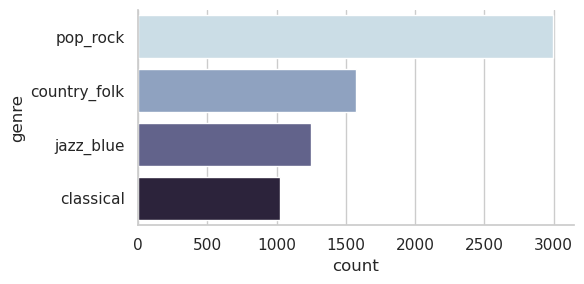

In [23]:
genre_all = cl.Counter(genre_train_openmic).most_common()
genre_train_openmic_plot = pd.DataFrame(columns=['genre', 'count'])

genre_train_openmic_plot['genre'] = [item[0] for item in genre_all]
genre_train_openmic_plot['count'] = [item[1] for item in genre_all]

genre_plot = genre_train_openmic_plot.loc[(genre_train_openmic_plot['count'] >= 100)]

sns.set_theme(context='notebook', style='whitegrid') # , font_scale=1.6)
sns.catplot(data=genre_plot, x='count', y='genre', kind='bar', height=3, aspect=2,
               legend_out=False, palette="ch:s=.25,rot=-.25")
plt.savefig('../results/openmic_train_genre_final.pdf', bbox_inches='tight')

In [24]:
genre_plot

,genre,count
0,pop_rock,2996
1,country_folk,1573
2,jazz_blue,1247
3,classical,1022


## Distribution summary
Number of samples per each instrument class and per genre in both datasets

In [25]:
(X_train_irmas, Y_train_irmas), (X_test_irmas, Y_test_irmas), (genre_train_irmas, genre_test_irmas) = deb.load_irmas()
(X_train_openmic, Y_train_openmic), (X_test_openmic, Y_test_openmic), \
(Y_mask_train, Y_mask_test), (genre_train_openmic, genre_test_openmic) = deb.load_openmic()

Load IRMAS data:


100%|██████████| 6705/6705 [00:01<00:00, 4978.55it/s]


# Train: 4997,  # Test: 1666
Load OpenMIC data:


100%|██████████| 5085/5085 [00:00<00:00, 16341.19it/s]


# Train: 6838,  # Test: 2491


In [26]:
print(cl.Counter(Y_train_irmas))
print(cl.Counter(genre_train_openmic))
print(cl.Counter(genre_train_irmas))

Counter({'guitar': 1051, 'piano': 551, 'voice': 545, 'organ': 508, 'saxophone': 476, 'violin': 437, 'trumpet': 427, 'clarinet': 378, 'flute': 330, 'cello': 294})
Counter({'pop_rock': 2996, 'country_folk': 1573, 'jazz_blue': 1247, 'classical': 1022})
Counter({'pop_rock': 1853, 'jazz_blue': 1539, 'classical': 1240, 'country_folk': 365})


In [27]:
# check data amount first; and then use equal amount of data for each instrument class from both datasets
openmic_inst = []
openmic_noninst = []
openmic_inst_genre = {inst:[] for inst in instrument_map}
irmas_inst = []
irmas_noninst = []
irmas_inst_genre = {inst:[] for inst in instrument_map}

for instrument in instrument_map:
    ###### OpenMIC
    # Map the instrument name to its column number
    inst_num = openmic_class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst_openmic = X_train_openmic[train_inst]
    genre_train_inst_openmic = genre_train_openmic[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    Y_train_noninst_openmic = Y_train_openmic[train_inst, inst_num] < 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst_openmic = X_test_openmic[test_inst]
    Y_test_inst_openmic = Y_test_openmic[test_inst, inst_num] >= 0.5

    ###### IRMAS
    # get the training and testing labels for each instrument
    X_train_inst_irmas = X_train_irmas
    genre_train_inst_irmas = genre_train_irmas
    X_test_inst_irmas = X_test_irmas

    Y_train_inst_irmas = Y_train_irmas==instrument
    Y_train_noninst_irmas = Y_train_irmas!=instrument
    Y_test_inst_irmas = Y_test_irmas==instrument

    ###### classification ######
    X_train_inst_openmic_true = X_train_inst_openmic[Y_train_inst_openmic]
    X_train_inst_openmic_false = X_train_inst_openmic[Y_train_noninst_openmic]

    X_train_inst_irmas_true = X_train_inst_irmas[Y_train_inst_irmas]
    X_train_inst_irmas_false = X_train_inst_irmas[Y_train_noninst_irmas]

    genre_train_inst_openmic_true = genre_train_inst_openmic[Y_train_inst_openmic]
    genre_train_inst_openmic_false = genre_train_inst_openmic[Y_train_noninst_openmic]

    genre_train_inst_irmas_true = genre_train_inst_irmas[Y_train_inst_irmas]
    genre_train_inst_irmas_false = genre_train_inst_irmas[Y_train_noninst_irmas]

    dim_inst = min(X_train_inst_openmic_true.shape[0], X_train_inst_irmas_true.shape[0])
    dim_noninst = min(X_train_inst_openmic_false.shape[0], X_train_inst_irmas_false.shape[0])

    X_train_inst_openmic_true, genre_train_inst_openmic_true = \
        deb.resample_data(X_train_inst_openmic_true, genre_train_inst_openmic_true, dim_inst)
    X_train_inst_irmas_true, genre_train_inst_irmas_true = \
        deb.resample_data(X_train_inst_irmas_true, genre_train_inst_irmas_true, dim_inst)

    X_train_inst_openmic_false, genre_train_inst_openmic_false = \
        deb.resample_data(X_train_inst_openmic_false, genre_train_inst_openmic_false, dim_noninst)
    X_train_inst_irmas_false, genre_train_inst_irmas_false = \
        deb.resample_data(X_train_inst_irmas_false, genre_train_inst_irmas_false, dim_noninst)
    
    X_train_inst_irmas = np.vstack((X_train_inst_irmas_true, X_train_inst_irmas_false))
    Y_train_inst_irmas = np.array([[True] * len(X_train_inst_irmas_true) + [False] * len(X_train_inst_irmas_false)]).reshape(-1,)
    genre_train_inst_irmas = np.hstack((genre_train_inst_irmas_true, genre_train_inst_irmas_false))

    X_train_inst_openmic = np.vstack((X_train_inst_openmic_true, X_train_inst_openmic_false))
    Y_train_inst_openmic = np.array([[True] * len(X_train_inst_openmic_true) + [False] * len(X_train_inst_openmic_false)]).reshape(-1,)
    genre_train_inst_openmic = np.hstack((genre_train_inst_openmic_true, genre_train_inst_openmic_false))

    openmic_inst.append(X_train_inst_openmic_true.shape[0])
    openmic_noninst.append(X_train_inst_openmic_false.shape[0])
    irmas_inst.append(X_train_inst_irmas_true.shape[0])
    irmas_noninst.append(X_train_inst_irmas_false.shape[0])

    openmic_inst_genre[instrument] = genre_train_inst_openmic_true
    irmas_inst_genre[instrument] = genre_train_inst_irmas_true

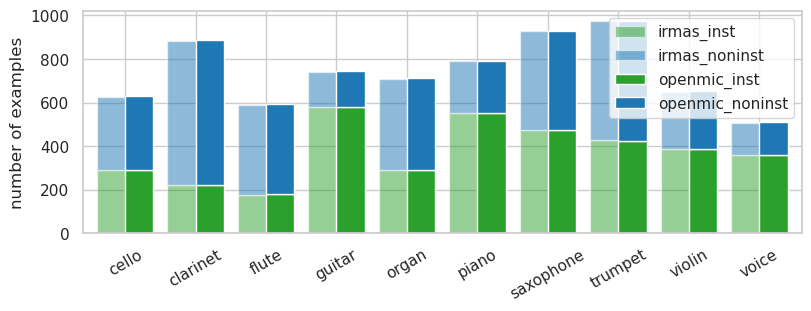

In [28]:
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.constrained_layout.use'] = True
df = pd.DataFrame({'instrument': list(instrument_map), 
                    'openmic_inst': openmic_inst,
                    'openmic_noninst': openmic_noninst,
                    'irmas_inst': irmas_inst,
                    'irmas_noninst': irmas_noninst})

fig, ax = plt.subplots(figsize=(8,3))
colors = ['tab:green', 'tab:blue']
df.plot(stacked=True, kind='bar', x='instrument', y=['irmas_inst','irmas_noninst'], ax=ax, position=1, width=0.4, color=colors, alpha=.5)
df.plot(stacked=True, kind='bar', x='instrument', y=['openmic_inst','openmic_noninst'], ax=ax, position=0, width=0.4, color=colors)
plt.xlim([-.6, len(df) - .4])
plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('number of examples')
plt.savefig('../results/train_set_distribution.pdf', bbox_inches='tight')

In [29]:
genre_info = pd.DataFrame(columns=['instrument', 'genre', 'examples', 'train_set'])

for inst in instrument_map:
    inst_genre_num = []
    for genre in list(genre_map):
        inst_genre_num.append(len(irmas_inst_genre[inst][irmas_inst_genre[inst] == genre]))

    genre_inst = pd.DataFrame(columns=['instrument', 'genre', 'examples', 'train_set'])
    genre_inst['instrument'] = [inst] * len(list(genre_map))
    genre_inst['genre'] = list(genre_map)
    genre_inst['examples'] = inst_genre_num
    genre_inst['train_set'] = ['irmas'] * len(list(genre_map))

    genre_info = genre_info.append(genre_inst)
    
for inst in instrument_map:
    inst_genre_num = []
    for genre in list(genre_map):
        inst_genre_num.append(len(openmic_inst_genre[inst][openmic_inst_genre[inst] == genre]))

    genre_inst = pd.DataFrame(columns=['instrument', 'genre', 'examples', 'train_set'])
    genre_inst['instrument'] = [inst] * len(list(genre_map))
    genre_inst['genre'] = list(genre_map)
    genre_inst['examples'] = inst_genre_num
    genre_inst['train_set'] = ['openmic'] * len(list(genre_map))

    genre_info = genre_info.append(genre_inst)

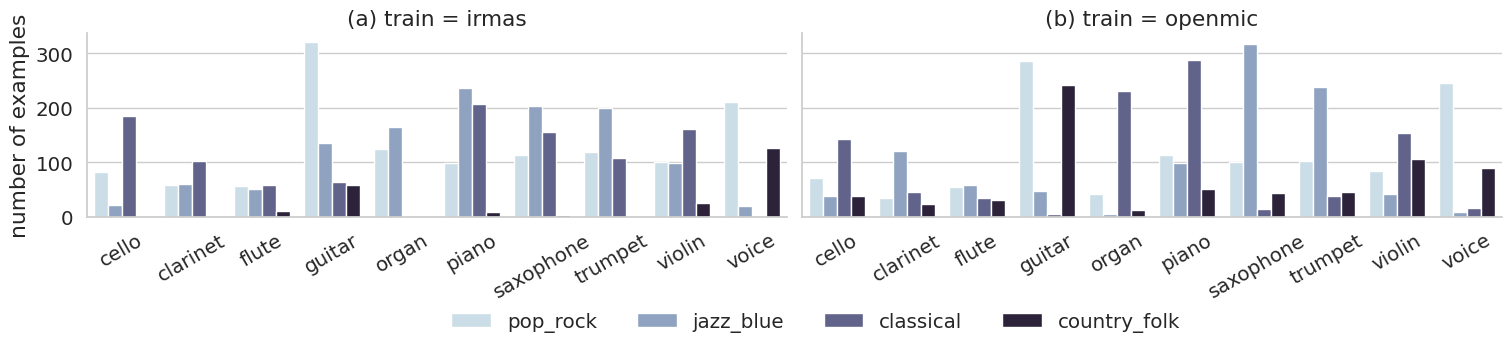

In [30]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.3)

ax = sns.catplot(data=genre_info, col='train_set', x='instrument', y='examples', hue='genre', kind='bar', height=3, aspect=2.5,
               legend_out=False, palette="ch:s=.25,rot=-.25")

a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")

ax.set(ylabel='number of examples')
ax.set(xlabel=None)
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.15), ncol=5, title=None, frameon=False)
plt.subplots_adjust(wspace=0.1)
ax.set_xticklabels(rotation=30)
plt.savefig('../results/genre_information.pdf', bbox_inches='tight')